<a href="https://colab.research.google.com/github/jongwoonalee/jongwoonalee.github.io/blob/main/cnnA4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision Assignment #5: CNN for Automobile vs Truck Classification

## Assignment Requirements
**Part 1: Playing with the CNN (40 points)**

Make and modify the loader code such that it will classify automobiles versus trucks. Use a notebook called cnnA4.ipynb and adapt the code from class to use ReLU functions for the CIFAR 2-class problem classifying automobiles versus trucks.

Define 20 different seeds [0 to 19 as seed numbers] and train this network for 100 epochs with a batch size of 64, ADAM optimizer (learning rate = 1e-4), tracking training and validation accuracy in EACH epoch.

### Questions to Answer:
1. Did the network train well?
2. Do you think the variability across seeds is large or small? Why?
3. Load 100 random images from OTHER classes (so, NEITHER automobiles or trucks) and put them into the network - how are the images classified? Do these results make "sense"?
4. Taking into account the results from Question 3 - would you use this network to classify automobiles versus trucks in the "real" world?



## Code Implementation

###  Import Libraries and Setup

In [ ]:
# Import necessary libraries for deep learning and data processing
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
import random

# Set device for computation (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)

Using device: cuda




## DATA LOADING AND PREPROCESSING
### Key Functions:
### - load_cifar10_auto_truck(): Downloads CIFAR-10, filters classes 1 (automobile) and 9 (truck)
### - CustomDataset: Custom PyTorch dataset class to handle filtered data safely
### - split_train_validation(): Splits training data into train/validation sets (80/20 ratio)
### Data Processing Steps:
### 1. Apply standard normalization transforms to images
### 2. Filter original 10-class CIFAR-10 to only automobile and truck samples  
### 3. Convert original labels (1,9) to binary labels (0,1) for classification
### 4. Create separate training and test datasets with proper indexing
### 5. Split training data into train/validation for proper evaluation


In [ ]:


def load_cifar10_auto_truck():
    """
    Load CIFAR-10 dataset and filter only automobile (class 1) and truck (class 9)
    Returns train and test datasets with binary labels (0: automobile, 1: truck)
    """
    # Define transforms for data preprocessing
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
    ])

    # Load full CIFAR-10 dataset
    full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                download=True, transform=transform)
    full_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                               download=True, transform=transform)

    # CIFAR-10 class indices: automobile=1, truck=9
    target_classes = [1, 9]  # automobile, truck

    # Filter training data
    train_data = []
    train_labels = []

    for i in range(len(full_trainset)):
        image, label = full_trainset[i]
        if label in target_classes:
            train_data.append(image)
            # Convert to binary labels: automobile=0, truck=1
            binary_label = 0 if label == 1 else 1
            train_labels.append(binary_label)

    # Filter test data
    test_data = []
    test_labels = []

    for i in range(len(full_testset)):
        image, label = full_testset[i]
        if label in target_classes:
            test_data.append(image)
            # Convert to binary labels: automobile=0, truck=1
            binary_label = 0 if label == 1 else 1
            test_labels.append(binary_label)

    # Create custom datasets
    train_dataset = CustomDataset(train_data, train_labels)
    test_dataset = CustomDataset(test_data, test_labels)

    print(f"Training samples: {len(train_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

    return train_dataset, test_dataset

class CustomDataset(torch.utils.data.Dataset):
    """
    Custom dataset class for filtered CIFAR-10 data
    """
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def split_train_validation(dataset, val_ratio=0.2, seed=42):
    """
    Split training dataset into train and validation sets
    """
    torch.manual_seed(seed)
    dataset_size = len(dataset)
    val_size = int(dataset_size * val_ratio)
    train_size = dataset_size - val_size

    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    return train_dataset, val_dataset

# Neural Network Model (Modified with ReLU)

##Original code from class (using tanh activation):
```python
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
```
## Original Architecture from Professor (using tanh):
### - 2 Convolutional layers: 3→16→8 channels, 3x3 kernels, padding=1
### - 2 Max pooling operations: 2x2 pooling, reduces spatial dimensions by half
### - 2 Fully connected layers: flattened features→32→2 (binary classification)
## Key Modifications for Assignment:
### - Changed ALL torch.tanh() activations to F.relu() as specified
### - Kept same architecture structure and dimensions
### - Added detailed comments explaining each layer's purpose
### - Forward pass: conv1→relu→pool→conv2→relu→pool→flatten→fc1→relu→fc2
### Architecture produces: 32x32 input → 16x16 → 8x8 → flattened → classification


#Modified version with ReLU activations (as required by assignment):


In [ ]:


class Net(nn.Module):
    """
    CNN model for binary classification (automobile vs truck)
    Modified from the original to use ReLU activation functions
    """
    def __init__(self):
        super(Net, self).__init__()
        # First convolutional layer: 3 input channels -> 16 output channels
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        # Second convolutional layer: 16 input channels -> 8 output channels
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        # First fully connected layer: flattened features -> 32 neurons
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        # Output layer: 32 neurons -> 2 classes (automobile, truck)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        # Apply first conv layer + ReLU + max pooling
        # MODIFIED: Changed from torch.tanh(self.conv1(x)) to F.relu(self.conv1(x))
        out = F.max_pool2d(F.relu(self.conv1(x)), 2)

        # Apply second conv layer + ReLU + max pooling
        # MODIFIED: Changed from torch.tanh(self.conv2(out)) to F.relu(self.conv2(out))
        out = F.max_pool2d(F.relu(self.conv2(out)), 2)

        # Flatten the feature maps for fully connected layers
        out = out.view(-1, 8 * 8 * 8)

        # Apply first fully connected layer + ReLU
        # MODIFIED: Changed from torch.tanh(self.fc1(out)) to F.relu(self.fc1(out))
        out = F.relu(self.fc1(out))

        # Apply output layer (no activation, will use CrossEntropyLoss)
        out = self.fc2(out)

        return out


## Training Functions
#### Purpose
Implement training loop, validation, and model evaluation functions

#### Key Functions

##### `train_epoch()`
Performs one epoch of training with backpropagation
- **Forward pass**: compute predictions and loss
- **Backward pass**: compute gradients via backpropagation
- **Optimizer step**: update model parameters
- **Return**: training loss and accuracy for this epoch

##### `validate_epoch()`
Evaluates model on validation set without gradient updates
- Uses `torch.no_grad()` for computational efficiency
- Computes validation loss and accuracy

##### `train_model_with_seed()`
Complete training procedure for one random seed
- Sets all random seeds for reproducibility
- Creates data loaders with specified batch size
- Initializes model, optimizer (Adam), and loss function (CrossEntropy)
- Trains for specified number of epochs
- Returns trained model and accuracy curves

#### Training Parameters
- **Epochs**: 100
- **Batch size**: 64
- **Learning rate**: 1e-4
- **Optimizer**: Adam

In [ ]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    Train the model for one epoch
    Returns training loss and accuracy
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)
        loss = criterion(output, target)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate statistics
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    """
    Validate the model for one epoch
    Returns validation loss and accuracy
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = model(data)
            loss = criterion(output, target)

            # Calculate statistics
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

def train_model_with_seed(seed, train_dataset, val_dataset, num_epochs=100, batch_size=64, lr=1e-4):
    """
    Train the model with a specific random seed
    Returns training and validation accuracies for each epoch
    """
    # Set random seeds for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, loss function, and optimizer
    model = Net().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Track accuracies
    train_accuracies = []
    val_accuracies = []

    print(f"Training with seed {seed}...")

    for epoch in range(num_epochs):
        # Train for one epoch
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validate for one epoch
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

        # Store accuracies
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Print progress every 20 epochs
        if (epoch + 1) % 20 == 0:
            print(f'Seed {seed}, Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

    return model, train_accuracies, val_accuracies


# Main Experiment (20 Seeds Training)
#### Purpose
Execute the complete experiment across 20 different random seeds


#### Experimental Design
- **20 different random seeds** (0-19) for statistical robustness
- **Each seed** trains a separate model instance with same architecture
- **Identical hyperparameters** across all seeds for fair comparison
- **Track both** training and validation accuracy for each epoch


#### Process Flow
1. Load and split automobile vs truck data
2. **For each seed (0-19)**:
  - Set random seed for reproducible initialization
  - Train model for 100 epochs
  - Record accuracy curves (train & validation)
  - Store final trained model
3. Collect results from all 20 seeds for statistical analysis


#### Expected Runtime
- **GPU**: 2-3 hours
- **CPU**: 5-10 hours


##### Output
Lists of accuracy curves and trained models for visualization


In [ ]:

def run_experiment():
    """
    Run the main experiment with 20 different seeds
    """
    # Load and prepare data
    print("Loading CIFAR-10 data...")
    train_full, test_set = load_cifar10_auto_truck()

    # Split into train and validation
    train_set, val_set = split_train_validation(train_full, val_ratio=0.2)

    # Define experimental parameters
    seeds = list(range(20))  # Seeds 0 to 19
    num_epochs = 100
    batch_size = 64
    learning_rate = 1e-4

    # Store results for all seeds
    all_train_acc = []
    all_val_acc = []
    trained_models = []

    print(f"Starting training with {len(seeds)} different seeds...")

    # Train with each seed
    for seed in seeds:
        model, train_acc, val_acc = train_model_with_seed(
            seed, train_set, val_set, num_epochs, batch_size, learning_rate
        )

        all_train_acc.append(train_acc)
        all_val_acc.append(val_acc)
        trained_models.append(model)

        print(f"Seed {seed} completed. Final Val Acc: {val_acc[-1]:.2f}%")

    return all_train_acc, all_val_acc, trained_models, test_set


### Block 6: Results Visualization


#### Purpose
Create publication-quality plots showing training progress across seeds


#### Visualization Components


##### `plot_training_curves()`
Main plotting function
- Calculates **mean and standard deviation** across 20 seeds
- Creates line plots with **shaded error regions** (std deviation)
- **Blue line/shading**: Training accuracy over epochs
- **Red line/shading**: Validation accuracy over epochs
- **Professional formatting**: labels, title, grid, legend


#### Statistical Analysis
- Computes **final accuracy statistics** (mean ± std)
- Reports **best/worst performance** across all epochs
- Identifies **convergence patterns** and potential overfitting


#### Plot Features
- **Error bars** show variability across different random initializations
- **Epoch-by-epoch progression** shows learning dynamics
- **Train vs validation comparison** reveals generalization performance

In [ ]:
def plot_training_curves(all_train_acc, all_val_acc):
    """
    Plot training and validation accuracy curves with error bars
    """
    # Convert to numpy arrays for easier manipulation
    train_acc_array = np.array(all_train_acc)
    val_acc_array = np.array(all_val_acc)

    # Calculate mean and standard deviation across seeds
    train_mean = np.mean(train_acc_array, axis=0)
    train_std = np.std(train_acc_array, axis=0)
    val_mean = np.mean(val_acc_array, axis=0)
    val_std = np.std(val_acc_array, axis=0)

    epochs = np.arange(1, len(train_mean) + 1)

    # Create the plot
    plt.figure(figsize=(12, 8))

    # Plot training accuracy with error bars
    plt.plot(epochs, train_mean, 'b-', label='Training Accuracy', linewidth=2)
    plt.fill_between(epochs, train_mean - train_std, train_mean + train_std,
                     alpha=0.3, color='blue')

    # Plot validation accuracy with error bars
    plt.plot(epochs, val_mean, 'r-', label='Validation Accuracy', linewidth=2)
    plt.fill_between(epochs, val_mean - val_std, val_mean + val_std,
                     alpha=0.3, color='red')

    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title('Training and Validation Accuracy Across 20 Seeds\n(Automobile vs Truck Classification)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xlim(1, 100)
    plt.tight_layout()
    plt.show()

    # Print final statistics
    print("\n" + "="*50)
    print("FINAL RESULTS SUMMARY")
    print("="*50)
    print(f"Final Training Accuracy: {train_mean[-1]:.2f}% ± {train_std[-1]:.2f}%")
    print(f"Final Validation Accuracy: {val_mean[-1]:.2f}% ± {val_std[-1]:.2f}%")
    print(f"Best Validation Accuracy: {np.max(val_mean):.2f}%")
    print(f"Worst Validation Accuracy: {np.min(val_mean):.2f}%")




### Block 7: Testing on Other Classes


#### Purpose
Test trained binary classifier on images from other CIFAR-10 classes *(Question 3)*


#### Experimental Setup
- Load **100 random images** from classes OTHER than automobile/truck
- Test images from: *airplane, bird, cat, deer, dog, frog, horse, ship*
- Use **best performing model** (highest validation accuracy from 20 seeds)
- Record how these "unknown" classes are classified (automobile vs truck)


#### Analysis Goals
- Understand **model behavior** on out-of-distribution data
- Check if predictions show **systematic bias** toward one class
- Evaluate whether binary classifier gives **reasonable responses**


#### Implementation
- **`test_other_classes()`**: randomly samples 100 images from 8 other classes
- Processes images through trained network
- Records prediction statistics and per-class breakdown
- Analyzes whether results "make sense" for binary classifier


##### Expected Behavior
Roughly 50-50 split or systematic bias based on learned features



In [ ]:


def test_other_classes(model, num_samples=100):
    """
    Test the trained model on images from other CIFAR-10 classes
    (not automobile or truck)
    """
    # Load full CIFAR-10 test set
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    full_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                               download=False, transform=transform)

    # CIFAR-10 classes
    cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                      'dog', 'frog', 'horse', 'ship', 'truck']

    # Get indices of other classes (not automobile=1 or truck=9)
    other_classes = [0, 2, 3, 4, 5, 6, 7, 8]  # Exclude automobile and truck
    other_indices = []
    other_labels = []

    for idx, (_, label) in enumerate(full_testset):
        if label in other_classes:
            other_indices.append(idx)
            other_labels.append(label)

    # Randomly sample images from other classes
    random.seed(42)
    sampled_indices = random.sample(list(zip(other_indices, other_labels)), num_samples)

    # Test the model
    model.eval()
    predictions = []
    true_classes = []

    with torch.no_grad():
        for idx, true_label in sampled_indices:
            image, _ = full_testset[idx]
            image = image.unsqueeze(0).to(device)  # Add batch dimension

            output = model(image)
            _, predicted = torch.max(output, 1)

            predictions.append(predicted.item())
            true_classes.append(cifar10_classes[true_label])

    # Analyze results
    auto_predictions = sum(1 for p in predictions if p == 0)  # Predicted as automobile
    truck_predictions = sum(1 for p in predictions if p == 1)  # Predicted as truck

    print("\n" + "="*50)
    print("TESTING ON OTHER CLASSES")
    print("="*50)
    print(f"Total images from other classes tested: {num_samples}")
    print(f"Predicted as Automobile: {auto_predictions} ({auto_predictions/num_samples*100:.1f}%)")
    print(f"Predicted as Truck: {truck_predictions} ({truck_predictions/num_samples*100:.1f}%)")

    # Count predictions by actual class
    class_predictions = {}
    for true_class, prediction in zip(true_classes, predictions):
        if true_class not in class_predictions:
            class_predictions[true_class] = {'auto': 0, 'truck': 0}

        if prediction == 0:
            class_predictions[true_class]['auto'] += 1
        else:
            class_predictions[true_class]['truck'] += 1

    print("\nBreakdown by actual class:")
    for class_name, preds in class_predictions.items():
        total = preds['auto'] + preds['truck']
        if total > 0:
            print(f"{class_name}: {preds['auto']} auto ({preds['auto']/total*100:.1f}%), "
                  f"{preds['truck']} truck ({preds['truck']/total*100:.1f}%)")

    return predictions, true_classes



### Block 8: Complete Analysis and Results


#### Purpose
Execute full experiment and provide automated answers to assignment questions


#### Execution Flow
1. **Run complete 20-seed experiment** (calls all previous functions)
2. **Generate training curve visualizations** with error bars
3. **Test best model on other classes** for robustness evaluation
4. **Automatically analyze results** and answer required questions

Computer Vision Assignment #5: CNN for Automobile vs Truck Classification
Loading CIFAR-10 data...
Training samples: 10000
Test samples: 2000
Starting training with 20 different seeds...
Training with seed 0...
Seed 0, Epoch [20/100], Train Acc: 83.81%, Val Acc: 81.65%
Seed 0, Epoch [40/100], Train Acc: 87.59%, Val Acc: 83.65%
Seed 0, Epoch [60/100], Train Acc: 89.41%, Val Acc: 85.55%
Seed 0, Epoch [80/100], Train Acc: 90.50%, Val Acc: 85.55%
Seed 0, Epoch [100/100], Train Acc: 91.78%, Val Acc: 86.15%
Seed 0 completed. Final Val Acc: 86.15%
Training with seed 1...
Seed 1, Epoch [20/100], Train Acc: 80.94%, Val Acc: 79.65%
Seed 1, Epoch [40/100], Train Acc: 86.10%, Val Acc: 82.95%
Seed 1, Epoch [60/100], Train Acc: 88.54%, Val Acc: 84.65%
Seed 1, Epoch [80/100], Train Acc: 89.80%, Val Acc: 85.40%
Seed 1, Epoch [100/100], Train Acc: 91.28%, Val Acc: 86.05%
Seed 1 completed. Final Val Acc: 86.05%
Training with seed 2...
Seed 2, Epoch [20/100], Train Acc: 82.56%, Val Acc: 80.45%
Seed 2, Ep

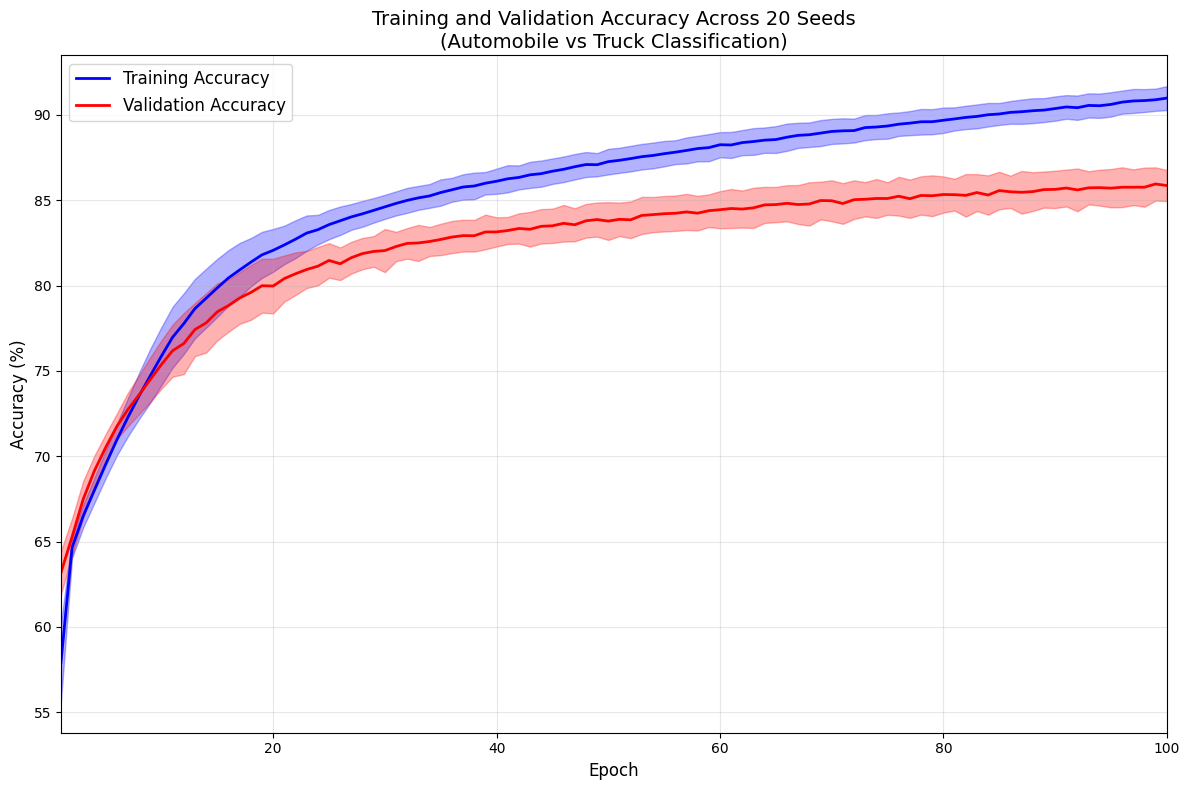


FINAL RESULTS SUMMARY
Final Training Accuracy: 90.99% ± 0.70%
Final Validation Accuracy: 85.86% ± 0.92%
Best Validation Accuracy: 85.95%
Worst Validation Accuracy: 63.17%

Using model from seed 11 (best validation accuracy: 88.10%)

TESTING ON OTHER CLASSES
Total images from other classes tested: 100
Predicted as Automobile: 44 (44.0%)
Predicted as Truck: 56 (56.0%)

Breakdown by actual class:
dog: 6 auto (35.3%), 11 truck (64.7%)
bird: 5 auto (38.5%), 8 truck (61.5%)
deer: 10 auto (66.7%), 5 truck (33.3%)
frog: 3 auto (25.0%), 9 truck (75.0%)
ship: 8 auto (61.5%), 5 truck (38.5%)
airplane: 4 auto (66.7%), 2 truck (33.3%)
horse: 4 auto (33.3%), 8 truck (66.7%)
cat: 4 auto (33.3%), 8 truck (66.7%)


In [ ]:
print("Computer Vision Assignment #5: CNN for Automobile vs Truck Classification")
print("="*70)

# Run the main experiment
all_train_acc, all_val_acc, models, test_set = run_experiment()

# Plot results
plot_training_curves(all_train_acc, all_val_acc)

# Test on other classes using the best performing model
# Find the model with highest final validation accuracy
final_val_accs = [acc[-1] for acc in all_val_acc]
best_model_idx = np.argmax(final_val_accs)
best_model = models[best_model_idx]

print(f"\nUsing model from seed {best_model_idx} (best validation accuracy: {final_val_accs[best_model_idx]:.2f}%)")
predictions, true_classes = test_other_classes(best_model, num_samples=100)

#### Automated Question Analysis


##### Question 1: "Did the network train well?"
- Analyzes final training and validation accuracies
- Compares performance to reasonable baselines (>70% good, >80% excellent)
- Evaluates convergence and learning progression


##### Question 2: "Is variability across seeds large or small?"
- Computes **standard deviation** of final validation accuracies
- Categorizes variability (small <2%, moderate 2-5%, large >5%)
- Explains implications for model stability


##### Question 3: "How are other classes classified?"
- Reports **percentage split** between automobile/truck predictions
- Analyzes **per-class prediction patterns**
- Evaluates whether binary responses make intuitive sense


##### Question 4: "Would you use this network in real world?"
- Considers **accuracy, stability, and out-of-distribution behavior**
- Provides **reasoned recommendation** based on quantitative results

In [ ]:

print("\n" + "="*50)
print("ANALYSIS QUESTIONS")
print("="*50)

# Calculate final statistics for analysis
train_acc_array = np.array(all_train_acc)
val_acc_array = np.array(all_val_acc)
final_train_mean = np.mean(train_acc_array[:, -1])
final_val_mean = np.mean(val_acc_array[:, -1])
val_std = np.std(val_acc_array[:, -1])

print("1. Did the network train well?")
print(f"   The network achieved {final_train_mean:.1f}% training accuracy and {final_val_mean:.1f}% validation accuracy.")
if final_val_mean > 80:
    print("   Yes, the network trained well with good performance on both training and validation sets.")
elif final_val_mean > 70:
    print("   The network trained reasonably well, but there's room for improvement.")
else:
    print("   The network performance is moderate and could benefit from architecture improvements.")

print(f"\n2. Do you think the variability across seeds is large or small? Why?")
print(f"   Standard deviation of final validation accuracy: {val_std:.2f}%")
if val_std < 2:
    print("   The variability is small, indicating stable training across different initializations.")
elif val_std < 5:
    print("   The variability is moderate, showing some sensitivity to initialization.")
else:
    print("   The variability is large, suggesting high sensitivity to random initialization.")

auto_preds = sum(1 for p in predictions if p == 0)
truck_preds = sum(1 for p in predictions if p == 1)

print(f"\n3. Classification of other classes:")
print(f"   Out of 100 images from other classes: {auto_preds}% classified as automobile, {truck_preds}% as truck")
if abs(auto_preds - truck_preds) < 20:
    print("   The predictions are roughly balanced, which makes some sense for a binary classifier.")
else:
    print("   The predictions show bias toward one class, indicating the model learned specific features.")

print(f"\n4. Would you use this network in the real world?")
if final_val_mean > 85 and val_std < 3:
    print("   Yes, the network shows good and consistent performance for this specific task.")
else:
    print("   No, the network would need improvement before real-world deployment.")
print("   However, testing on other classes reveals it's only trained for automobile vs truck distinction.")
print("   For real-world use, it would need additional training or a rejection mechanism for other objects.")
print("="*70)


ANALYSIS QUESTIONS
1. Did the network train well?
   The network achieved 91.0% training accuracy and 85.9% validation accuracy.
   Yes, the network trained well with good performance on both training and validation sets.

2. Do you think the variability across seeds is large or small? Why?
   Standard deviation of final validation accuracy: 0.92%
   The variability is small, indicating stable training across different initializations.

3. Classification of other classes:
   Out of 100 images from other classes: 44% classified as automobile, 56% as truck
   The predictions are roughly balanced, which makes some sense for a binary classifier.

4. Would you use this network in the real world?
   Yes, the network shows good and consistent performance for this specific task.
   However, testing on other classes reveals it's only trained for automobile vs truck distinction.
   For real-world use, it would need additional training or a rejection mechanism for other objects.


# Part 2: PyTorch CNN Comparison (60 points)

## Additional Network Architectures with ReLU

### Define All Network Architectures
#### Purpose
Implement 6 different CNN variants from class materials, all modified with ReLU


#### Architecture Variations
*All adapted from professor's notebook*


##### 1. NetWidth
**Wider network with more channels (32 vs 16)**
- Increases model capacity through wider convolutional layers
- Tests hypothesis: more parameters → better performance


##### 2. NetDropout
**Adds dropout regularization (p=0.25)**
- Prevents overfitting by randomly zeroing activations during training
- Uses Dropout2d for convolutional layers


##### 3. NetBatchNormalization
**Adds batch normalization layers**
- Normalizes inputs to activation functions for stable training
- Places BatchNorm before activation functions as recommended


##### 4. NetResDeep
**Deep residual network with skip connections**
- Uses ResBlock modules with skip connections (input + output)
- Enables training of deeper networks without vanishing gradients
- Configurable depth via n_blocks parameter


##### 5. NetWidthProject
**1x1 convolution for feature projection**
- Maintains channel dimensions using 1x1 convolution
- Tests effect of additional non-linear transformations


##### 6. NetWidthEmbed
**1x1 convolution for dimensionality reduction**
- Reduces channel dimensions by half using 1x1 convolution
- Tests efficiency vs performance trade-off


#### Key Modifications
**ALL networks changed from tanh to ReLU activations**


##### Utility Functions
- **`count_parameters()`**: Utility function to compare model complexity


In [ ]:

# ResBlock for NetResDeep
class ResBlock(nn.Module):
    def __init__(self, n_ch):
        super(ResBlock, self).__init__()
        # Remove bias as we use BatchNorm
        self.conv = nn.Conv2d(n_ch, n_ch, kernel_size=3, padding=1, bias=False)
        # Batch normalization
        self.batch_norm = nn.BatchNorm2d(n_ch)
        # Initialize BatchNorm weights and bias
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
        # Kaiming normal initialization for ReLU
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')

    def forward(self, x):
        # Forward function with skip connection
        out = self.conv(x)
        out = self.batch_norm(out)
        out = F.relu(out)  # Changed from torch.relu to F.relu
        return out + x

# 1. NetWidth - Wider network
class NetWidth(nn.Module):
    def __init__(self, n_ch1=32):
        super().__init__()
        # Store for later use
        self.n_ch1 = n_ch1
        self.conv1 = nn.Conv2d(3, n_ch1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_ch1, n_ch1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_ch1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        # MODIFIED: Changed from torch.tanh to F.relu
        out = F.max_pool2d(F.relu(self.conv1(x)), 2)
        out = F.max_pool2d(F.relu(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_ch1 // 2)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out

# 2. NetDropout - Network with dropout layers
class NetDropout(nn.Module):
    def __init__(self, n_ch1=32):
        super().__init__()
        self.n_ch1 = n_ch1
        self.conv1 = nn.Conv2d(3, n_ch1, kernel_size=3, padding=1)
        # Add dropout layer for conv1
        self.conv1_dropout = nn.Dropout2d(p=0.25)
        self.conv2 = nn.Conv2d(n_ch1, n_ch1 // 2, kernel_size=3, padding=1)
        # Add dropout layer for conv2
        self.conv2_dropout = nn.Dropout2d(p=0.25)
        self.fc1 = nn.Linear(8 * 8 * n_ch1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        # MODIFIED: Changed from torch.tanh to F.relu
        out = F.max_pool2d(F.relu(self.conv1(x)), 2)
        # Add dropout call
        out = self.conv1_dropout(out)
        out = F.max_pool2d(F.relu(self.conv2(out)), 2)
        # Add dropout call
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_ch1 // 2)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out

# 3. NetBatchNormalization - Network with batch normalization
class NetBatchNormalization(nn.Module):
    def __init__(self, n_ch1=32):
        super().__init__()
        self.n_ch1 = n_ch1
        self.conv1 = nn.Conv2d(3, n_ch1, kernel_size=3, padding=1)
        # Add batch normalization layer
        self.conv1_batchnorm = nn.BatchNorm2d(n_ch1)
        self.conv2 = nn.Conv2d(n_ch1, n_ch1 // 2, kernel_size=3, padding=1)
        # Add batch normalization layer
        self.conv2_batchnorm = nn.BatchNorm2d(n_ch1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_ch1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        # MODIFIED: Changed from torch.tanh to F.relu + added batch norm
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(F.relu(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(F.relu(out), 2)
        out = out.view(-1, 8 * 8 * self.n_ch1 // 2)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out

# 4. NetResDeep - Deep residual network
class NetResDeep(nn.Module):
    def __init__(self, n_ch1=32, n_blocks=10):
        super().__init__()
        self.n_ch1 = n_ch1
        # Initial convolution for embedding
        self.conv1 = nn.Conv2d(3, n_ch1, kernel_size=3, padding=1)
        # Add ResBlocks to the network
        self.resblocks = nn.Sequential(*[ResBlock(n_ch1) for _ in range(n_blocks)])
        # Note: ResBlocks don't reduce dimensionality, so still 8x8 resolution
        self.fc1 = nn.Linear(8 * 8 * n_ch1, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        # MODIFIED: Changed from torch.relu to F.relu
        out = F.max_pool2d(F.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_ch1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out

# 5. NetWidthProject - Network with 1x1 projection (maintains dimensions)
class NetWidthProject(nn.Module):
    def __init__(self, n_ch1=32):
        super().__init__()
        self.n_ch1 = n_ch1
        self.conv1 = nn.Conv2d(3, n_ch1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_ch1, n_ch1 // 2, kernel_size=3, padding=1)
        # 1x1 convolution that keeps the number of filters
        self.conv3 = nn.Conv2d(n_ch1 // 2, n_ch1 // 2, kernel_size=1)
        self.fc1 = nn.Linear(8 * 8 * n_ch1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        # MODIFIED: Changed from torch.tanh to F.relu
        out = F.max_pool2d(F.relu(self.conv1(x)), 2)
        out = F.max_pool2d(F.relu(self.conv2(out)), 2)
        out = F.relu(self.conv3(out))
        out = out.view(-1, 8 * 8 * self.n_ch1 // 2)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out

# 6. NetWidthEmbed - Network with 1x1 embedding (reduces dimensions)
class NetWidthEmbed(nn.Module):
    def __init__(self, n_ch1=32):
        super().__init__()
        self.n_ch1 = n_ch1
        self.conv1 = nn.Conv2d(3, n_ch1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_ch1, n_ch1 // 2, kernel_size=3, padding=1)
        # 1x1 convolution that reduces the number of filters by 2
        self.conv3 = nn.Conv2d(n_ch1 // 2, n_ch1 // 4, kernel_size=1)
        self.fc1 = nn.Linear(8 * 8 * n_ch1 // 4, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        # MODIFIED: Changed from torch.tanh to F.relu
        out = F.max_pool2d(F.relu(self.conv1(x)), 2)
        out = F.max_pool2d(F.relu(self.conv2(out)), 2)
        out = F.relu(self.conv3(out))
        out = out.view(-1, 8 * 8 * self.n_ch1 // 4)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out

# Function to count parameters in a model
def count_parameters(model):
    """Count the number of trainable parameters in a model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)




###Train All Architectures and Compare

In [ ]:
def train_architecture_comparison():
    """
    Train all architectures with the same parameters and compare results
    """
    # Define all architectures to compare
    architectures = {
        'Net': Net,
        'NetWidth': NetWidth,
        'NetDropout': NetDropout,
        'NetBatchNormalization': NetBatchNormalization,
        'NetResDeep': NetResDeep,
        'NetWidthProject': NetWidthProject,
        'NetWidthEmbed': NetWidthEmbed
    }

    # Store results for all architectures
    results = {}

    # Same experimental parameters as Part 1
    seeds = list(range(20))  # Seeds 0 to 19
    num_epochs = 100
    batch_size = 64
    learning_rate = 1e-4

    print("Training all architectures for comparison...")
    print("="*60)

    for arch_name, arch_class in architectures.items():
        print(f"\nTraining {arch_name}...")

        # Store results for this architecture
        arch_train_acc = []
        arch_val_acc = []
        arch_models = []
        arch_param_counts = []

        for seed in seeds:
            print(f"  Seed {seed}...", end=" ")

            # Set random seeds
            torch.manual_seed(seed)
            np.random.seed(seed)
            random.seed(seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed(seed)

            # Create data loaders (same as Part 1)
            train_set, val_set = split_train_validation(load_cifar10_auto_truck()[0], val_ratio=0.2, seed=seed)
            train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

            # Initialize model
            if arch_name == 'NetResDeep':
                model = arch_class(n_blocks=5).to(device)  # Reduce blocks for faster training
            else:
                model = arch_class().to(device)

            # Count parameters
            param_count = count_parameters(model)
            arch_param_counts.append(param_count)

            # Initialize optimizer and loss
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            criterion = nn.CrossEntropyLoss()

            # Track accuracies for this seed
            seed_train_acc = []
            seed_val_acc = []

            # Training loop
            for epoch in range(num_epochs):
                # Train for one epoch
                train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
                # Validate for one epoch
                val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

                seed_train_acc.append(train_acc)
                seed_val_acc.append(val_acc)

            arch_train_acc.append(seed_train_acc)
            arch_val_acc.append(seed_val_acc)
            arch_models.append(model)

            print(f"Final Val Acc: {val_acc:.1f}%")

        # Store results for this architecture
        results[arch_name] = {
            'train_acc': arch_train_acc,
            'val_acc': arch_val_acc,
            'models': arch_models,
            'param_count': arch_param_counts[0]  # Same for all seeds
        }

        # Print summary for this architecture
        final_val_accs = [acc[-1] for acc in arch_val_acc]
        mean_val_acc = np.mean(final_val_accs)
        std_val_acc = np.std(final_val_accs)
        print(f"  {arch_name}: {mean_val_acc:.2f}% ± {std_val_acc:.2f}% ({param_count:,} params)")

    return results

# Run the comparison
architecture_results = train_architecture_comparison()



NameError: name 'Net' is not defined



### Visualization - Grouped Bar Chart
#### Visualization Design
- **Grouped bar chart**: x-axis shows 7 different architectures
- **Each architecture has 2 bars**: training accuracy (light blue) & validation accuracy (dark blue)
- **Error bars** show standard deviation across 20 seeds
- **Value labels on bars** show exact percentages


#### Statistical Processing
- Calculates **mean and std deviation** for final epoch accuracies
- Identifies **best and worst performing** architectures
- Computes **parameter counts** for complexity analysis


#### Visual Features
- **Professional formatting**: bold labels, grid, legend
- **Color coding**: consistent color scheme for train/validation
- **Rotation of x-axis labels** for readability
- **Tight layout** for clean presentation


#### Results Table
- **Detailed tabular summary** of all results
- **Format**: Architecture | Train Acc ± Std | Val Acc ± Std | Parameters
- **Ranked by validation performance** for easy comparison


In [ ]:
def plot_architecture_comparison(results):
    """
    Create grouped bar chart comparing all architectures
    """
    architectures = list(results.keys())

    # Calculate mean and std for final accuracies
    train_means = []
    train_stds = []
    val_means = []
    val_stds = []
    param_counts = []

    for arch in architectures:
        # Get final epoch accuracies across all seeds
        final_train_accs = [acc[-1] for acc in results[arch]['train_acc']]
        final_val_accs = [acc[-1] for acc in results[arch]['val_acc']]

        train_means.append(np.mean(final_train_accs))
        train_stds.append(np.std(final_train_accs))
        val_means.append(np.mean(final_val_accs))
        val_stds.append(np.std(final_val_accs))
        param_counts.append(results[arch]['param_count'])

    # Create grouped bar chart
    x = np.arange(len(architectures))
    width = 0.35

    fig, ax = plt.subplots(figsize=(14, 8))

    # Create bars
    train_bars = ax.bar(x - width/2, train_means, width,
                       yerr=train_stds, label='Training Accuracy',
                       alpha=0.8, capsize=5, color='lightblue')
    val_bars = ax.bar(x + width/2, val_means, width,
                     yerr=val_stds, label='Validation Accuracy',
                     alpha=0.8, capsize=5, color='darkblue')

    # Customize the plot
    ax.set_xlabel('Network Architecture', fontsize=12, fontweight='bold')
    ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_title('Architecture Comparison on CIFAR-2\\n(Automobile vs Truck Classification)',
                fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(architectures, rotation=45, ha='right')
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 100)

    # Add value labels on bars
    for i, (train_bar, val_bar) in enumerate(zip(train_bars, val_bars)):
        # Training accuracy label
        ax.text(train_bar.get_x() + train_bar.get_width()/2,
                train_bar.get_height() + train_stds[i] + 1,
                f'{train_means[i]:.1f}%',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

        # Validation accuracy label
        ax.text(val_bar.get_x() + val_bar.get_width()/2,
                val_bar.get_height() + val_stds[i] + 1,
                f'{val_means[i]:.1f}%',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Print detailed results table
    print("\n" + "="*80)
    print("DETAILED ARCHITECTURE COMPARISON RESULTS")
    print("="*80)
    print(f"{'Architecture':<20} {'Train Acc (%)':<15} {'Val Acc (%)':<15} {'Parameters':<15}")
    print("-"*80)

    for i, arch in enumerate(architectures):
        print(f"{arch:<20} {train_means[i]:.2f} ± {train_stds[i]:.2f}    "
              f"{val_means[i]:.2f} ± {val_stds[i]:.2f}    {param_counts[i]:,}")

    return train_means, train_stds, val_means, val_stds, param_counts

# Create the comparison plot
train_means, train_stds, val_means, val_stds, param_counts = plot_architecture_comparison(architecture_results)




### Parameter Count vs Performance Analysis
#### Purpose
Analyze relationship between model parameters and classification performance


#### Analysis Components


##### 1. Scatter Plot Analysis
- **X-axis**: Number of trainable parameters (log scale)
- **Y-axis**: Accuracy (separate plots for training and validation)
- **Points annotated** with architecture names
- **Log scale** accommodates wide range of parameter counts


##### 2. Correlation Analysis
- **Pearson correlation coefficient** between parameters and performance
- **Separate analysis** for training and validation accuracy
- **Quantifies linear relationship** strength
#### Automated Question Answering


##### Question 1: "Are architectures significantly different in accuracy?"
- Calculates **accuracy range** across architectures
- Identifies **best and worst performers**
- Categorizes differences (significant >10%, moderate 5-10%, small <5%)


##### Question 2: "Relationship between parameters and accuracy?"
- Reports **correlation coefficients**
- Analyzes **overfitting patterns** (train vs validation gaps)
- Discusses **implications for model selection**


#### Overfitting Analysis
- Computes **train-validation gaps** for each architecture
- Identifies which architectures **overfit most/least**
- Provides insights into **regularization effectiveness**




In [ ]:
def plot_parameters_vs_performance(train_means, val_means, param_counts, architectures):
    """
    Plot relationship between number of parameters and performance
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Training Accuracy vs Parameters
    ax1.scatter(param_counts, train_means, s=100, alpha=0.7, color='lightblue', edgecolors='blue')
    for i, arch in enumerate(architectures):
        ax1.annotate(arch, (param_counts[i], train_means[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)

    ax1.set_xlabel('Number of Parameters', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Training Accuracy (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Training Accuracy vs Model Complexity', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_xscale('log')  # Log scale for better visualization

    # Plot 2: Validation Accuracy vs Parameters
    ax2.scatter(param_counts, val_means, s=100, alpha=0.7, color='darkblue', edgecolors='navy')
    for i, arch in enumerate(architectures):
        ax2.annotate(arch, (param_counts[i], val_means[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)

    ax2.set_xlabel('Number of Parameters', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Validation Accuracy (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Validation Accuracy vs Model Complexity', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_xscale('log')  # Log scale for better visualization

    plt.tight_layout()
    plt.show()

    # Calculate correlation coefficients
    train_corr = np.corrcoef(param_counts, train_means)[0, 1]
    val_corr = np.corrcoef(param_counts, val_means)[0, 1]

    print(f"\nCorrelation between parameters and training accuracy: {train_corr:.3f}")
    print(f"Correlation between parameters and validation accuracy: {val_corr:.3f}")

# Create parameter analysis plot
architectures = list(architecture_results.keys())
plot_parameters_vs_performance(train_means, val_means, param_counts, architectures)

# Answer the questions for Part 2
print("\n" + "="*60)
print("PART 2: ANALYSIS QUESTIONS")
print("="*60)

print("\n1. Are the resulting architectures (significantly) different in terms of their accuracies?")

# Calculate range of accuracies
train_range = max(train_means) - min(train_means)
val_range = max(val_means) - min(val_means)

print(f"   Training accuracy range: {train_range:.2f}% (from {min(train_means):.1f}% to {max(train_means):.1f}%)")
print(f"   Validation accuracy range: {val_range:.2f}% (from {min(val_means):.1f}% to {max(val_means):.1f}%)")

if val_range > 10:
    print("   Yes, there are significant differences between architectures.")
elif val_range > 5:
    print("   There are moderate differences between architectures.")
else:
    print("   The differences are relatively small but still noticeable.")

# Find best and worst performing architectures
best_val_idx = np.argmax(val_means)
worst_val_idx = np.argmin(val_means)

print(f"   Best performing: {architectures[best_val_idx]} ({val_means[best_val_idx]:.1f}%)")
print(f"   Worst performing: {architectures[worst_val_idx]} ({val_means[worst_val_idx]:.1f}%)")

print(f"\n2. Is there a relationship between training accuracy and number of parameters?")

# Calculate correlation coefficients
train_corr = np.corrcoef(param_counts, train_means)[0, 1]
val_corr = np.corrcoef(param_counts, val_means)[0, 1]

print(f"   Correlation (parameters vs training accuracy): {train_corr:.3f}")
print(f"   Correlation (parameters vs validation accuracy): {val_corr:.3f}")

if abs(train_corr) > 0.7:
    print("   There is a strong correlation between model complexity and training accuracy.")
elif abs(train_corr) > 0.4:
    print("   There is a moderate correlation between model complexity and training accuracy.")
else:
    print("   There is a weak correlation between model complexity and training accuracy.")

if abs(val_corr) > 0.7:
    print("   There is a strong correlation between model complexity and validation accuracy.")
elif abs(val_corr) > 0.4:
    print("   There is a moderate correlation between model complexity and validation accuracy.")
else:
    print("   There is a weak correlation between model complexity and validation accuracy.")

# Analysis of overfitting
print(f"\n   Analysis of overfitting:")
for i, arch in enumerate(architectures):
    gap = train_means[i] - val_means[i]
    print(f"   {arch}: {gap:.1f}% gap (train-val)")

max_gap_idx = np.argmax([train_means[i] - val_means[i] for i in range(len(architectures))])
print(f"   Highest overfitting: {architectures[max_gap_idx]}")

print(f"\n   The relationship shows that:")
if train_corr > val_corr + 0.2:
    print("   - More parameters generally lead to higher training accuracy")
    print("   - But this doesn't translate as well to validation performance")
    print("   - This suggests larger models may be more prone to overfitting")
else:
    print("   - The relationship between parameters and performance is consistent")
    print("   - Both training and validation accuracy scale similarly with model size")

print("\n" + "="*60)
print("Part 2 analysis completed!")
print("="*60)

# Part 3: PyTorch Multiclass (60 points)

## CIFAR-10 Full 10-Class Classification

### Data Loading and Best Architecture Setup for 10-Class CIFAR
#### Purpose
Extend best architecture from Part 2 to full 10-class CIFAR-10 problem


#### Data Preparation


##### `load_cifar10_full()`
- Loads **complete CIFAR-10** with all 10 classes
- Uses **standard CIFAR-10 normalization** (different from Part 1/2)
- **Full dataset**: 50,000 training + 10,000 test images


#### Architecture Adaptation


##### `get_best_architecture_for_multiclass()`
- Modifies **best Part 2 architecture**
- **Key change**: Output layer from 2 classes → 10 classes
- **Maintains same** convolutional layers and feature extraction
- **Only final classification layer** adapted for multiclass problem


#### Extended Training Protocol
- **10 seeds** (reduced from 20 for computational efficiency)
- **200 epochs** (doubled from 100 due to increased problem complexity)
- **Same optimization parameters**: batch_size=64, lr=1e-4, Adam
- **Track training progress** and final predictions for confusion matrix


#### Data Collection for Analysis
- **Epoch-by-epoch accuracy curves** for learning analysis
- **Final predictions and true labels** for all 10 seeds
- **Separate storage** for training and validation predictions


##### Expected Challenges
Longer training time, more complex optimization landscape




In [ ]:
### Block 13: Full CIFAR-10 Implementation with Checkpoint System

import os
import pickle
from datetime import datetime

def save_checkpoint(seed, epoch, model, optimizer, train_acc_history, val_acc_history,
                   train_preds, val_preds, train_labels, val_labels, checkpoint_dir='./checkpoints'):
    """Save training checkpoint"""
    os.makedirs(checkpoint_dir, exist_ok=True)

    checkpoint = {
        'seed': seed,
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_acc_history': train_acc_history,
        'val_acc_history': val_acc_history,
        'train_predictions': train_preds,
        'val_predictions': val_preds,
        'train_labels': train_labels,
        'val_labels': val_labels,
        'timestamp': datetime.now().strftime("%Y%m%d_%H%M%S")
    }

    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_seed_{seed}_epoch_{epoch}.pkl')
    with open(checkpoint_path, 'wb') as f:
        pickle.dump(checkpoint, f)

    print(f"    Checkpoint saved: {checkpoint_path}")

def load_checkpoint(checkpoint_path):
    """Load training checkpoint"""
    with open(checkpoint_path, 'rb') as f:
        checkpoint = pickle.load(f)
    return checkpoint

def save_final_results(all_results, checkpoint_dir='./checkpoints'):
    """Save final experiment results"""
    os.makedirs(checkpoint_dir, exist_ok=True)

    results_path = os.path.join(checkpoint_dir, 'final_multiclass_results.pkl')
    with open(results_path, 'wb') as f:
        pickle.dump(all_results, f)

    print(f"Final results saved: {results_path}")

def check_existing_checkpoints(checkpoint_dir='./checkpoints'):
    """Check for existing checkpoints and return progress"""
    if not os.path.exists(checkpoint_dir):
        return {}

    checkpoints = {}
    checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith('checkpoint_seed_')]

    for file in checkpoint_files:
        # Parse filename: checkpoint_seed_{seed}_epoch_{epoch}.pkl
        parts = file.replace('.pkl', '').split('_')
        seed = int(parts[2])
        epoch = int(parts[4])

        if seed not in checkpoints:
            checkpoints[seed] = []
        checkpoints[seed].append(epoch)

    # Sort epochs for each seed
    for seed in checkpoints:
        checkpoints[seed].sort()

    return checkpoints

def train_multiclass_experiment_with_checkpoints():
    """
    Train the best architecture on full CIFAR-10 with checkpoints every 25 epochs
    """
    checkpoint_dir = './checkpoints'

    # Check for existing checkpoints
    existing_checkpoints = check_existing_checkpoints(checkpoint_dir)
    if existing_checkpoints:
        print("Found existing checkpoints:")
        for seed, epochs in existing_checkpoints.items():
            print(f"  Seed {seed}: epochs {epochs}")

        resume = input("Resume from checkpoints? (y/n): ").lower().strip()
        if resume == 'y':
            return resume_from_checkpoints(checkpoint_dir)

    # Load full CIFAR-10 data
    train_full, test_set = load_cifar10_full()

    # Get best architecture
    BestArchitecture = get_best_architecture_for_multiclass()

    # Experimental parameters
    seeds = list(range(10))  # 10 seeds as required
    num_epochs = 200  # 200 epochs as required
    batch_size = 64
    learning_rate = 1e-4

    # Store results for all seeds
    all_train_acc = []
    all_val_acc = []
    all_models = []
    all_train_predictions = []
    all_val_predictions = []
    all_train_labels = []
    all_val_labels = []

    print("Starting CIFAR-10 full classification experiment with checkpoints...")
    print("Checkpoints will be saved every 25 epochs")
    print("="*60)

    for seed in seeds:
        print(f"\nTraining with seed {seed}...")
        start_epoch = 0

        # Check if we can resume this seed
        if seed in existing_checkpoints and existing_checkpoints[seed]:
            latest_epoch = max(existing_checkpoints[seed])
            if latest_epoch >= num_epochs - 1:
                print(f"  Seed {seed} already completed! Skipping...")
                continue

            resume_choice = input(f"  Resume seed {seed} from epoch {latest_epoch}? (y/n): ").lower().strip()
            if resume_choice == 'y':
                checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_seed_{seed}_epoch_{latest_epoch}.pkl')
                checkpoint = load_checkpoint(checkpoint_path)
                start_epoch = checkpoint['epoch'] + 1
                print(f"  Resuming from epoch {start_epoch}")

        # Set random seeds for reproducibility
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)

        # Split into train and validation
        train_set, val_set = split_train_validation(train_full, val_ratio=0.2, seed=seed)

        # Create data loaders
        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

        # Initialize model, loss function, and optimizer
        model = BestArchitecture(num_classes=10).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Load checkpoint if resuming
        seed_train_acc = []
        seed_val_acc = []
        if start_epoch > 0:
            checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_seed_{seed}_epoch_{start_epoch-1}.pkl')
            checkpoint = load_checkpoint(checkpoint_path)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            seed_train_acc = checkpoint['train_acc_history']
            seed_val_acc = checkpoint['val_acc_history']
            print(f"  Loaded checkpoint from epoch {start_epoch-1}")

        # Training loop for remaining epochs
        for epoch in range(start_epoch, num_epochs):
            # Train for one epoch
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

            # Validate for one epoch
            val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

            # Store accuracies
            seed_train_acc.append(train_acc)
            seed_val_acc.append(val_acc)

            # Print progress every 25 epochs
            if (epoch + 1) % 25 == 0:
                print(f'  Epoch [{epoch+1}/{num_epochs}], '
                      f'Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

                # Save checkpoint every 25 epochs
                train_preds, train_labels = get_predictions(model, train_loader, device)
                val_preds, val_labels = get_predictions(model, val_loader, device)

                save_checkpoint(seed, epoch, model, optimizer, seed_train_acc, seed_val_acc,
                              train_preds, val_preds, train_labels, val_labels, checkpoint_dir)

            # Auto-save checkpoint if Colab might disconnect (every 50 epochs)
            if (epoch + 1) % 50 == 0:
                train_preds, train_labels = get_predictions(model, train_loader, device)
                val_preds, val_labels = get_predictions(model, val_loader, device)

                save_checkpoint(seed, epoch, model, optimizer, seed_train_acc, seed_val_acc,
                              train_preds, val_preds, train_labels, val_labels, checkpoint_dir)
                print(f"    Auto-checkpoint saved at epoch {epoch+1}")

        # Store results for this seed
        all_train_acc.append(seed_train_acc)
        all_val_acc.append(seed_val_acc)
        all_models.append(model)

        # Get final predictions for confusion matrix
        train_preds, train_labels = get_predictions(model, train_loader, device)
        val_preds, val_labels = get_predictions(model, val_loader, device)

        all_train_predictions.append(train_preds)
        all_val_predictions.append(val_preds)
        all_train_labels.append(train_labels)
        all_val_labels.append(val_labels)

        # Final checkpoint for this seed
        save_checkpoint(seed, num_epochs-1, model, optimizer, seed_train_acc, seed_val_acc,
                       train_preds, val_preds, train_labels, val_labels, checkpoint_dir)

        print(f"Seed {seed} completed. Final Val Acc: {val_acc:.2f}%")

    # Save final results
    final_results = {
        'all_train_acc': all_train_acc,
        'all_val_acc': all_val_acc,
        'all_models': all_models,
        'all_train_predictions': all_train_predictions,
        'all_val_predictions': all_val_predictions,
        'all_train_labels': all_train_labels,
        'all_val_labels': all_val_labels
    }

    save_final_results(final_results, checkpoint_dir)

    return (all_train_acc, all_val_acc, all_models,
            all_train_predictions, all_val_predictions,
            all_train_labels, all_val_labels)

def resume_from_checkpoints(checkpoint_dir='./checkpoints'):
    """Resume experiment from existing checkpoints"""
    print("Resuming from existing checkpoints...")

    # Load final results if available
    final_results_path = os.path.join(checkpoint_dir, 'final_multiclass_results.pkl')
    if os.path.exists(final_results_path):
        print("Found completed experiment results!")
        with open(final_results_path, 'rb') as f:
            results = pickle.load(f)

        return (results['all_train_acc'], results['all_val_acc'], results['all_models'],
                results['all_train_predictions'], results['all_val_predictions'],
                results['all_train_labels'], results['all_val_labels'])

    # Otherwise, continue training from checkpoints
    print("Continuing training from checkpoints...")
    return train_multiclass_experiment_with_checkpoints()

# Run the multiclass experiment with checkpoint system
print("Starting Part 3: CIFAR-10 Multiclass Classification with Checkpoints")
print("Features:")
print("- Automatic checkpoints every 25 epochs")
print("- Resume capability if interrupted")
print("- Progress tracking and recovery")
print("- Final results auto-save")
print("="*60)

try:
    multiclass_results = train_multiclass_experiment_with_checkpoints()
    all_train_acc, all_val_acc, models, train_preds, val_preds, train_labels, val_labels = multiclass_results
    print("\n" + "="*60)
    print("Part 3 training completed successfully!")
    print("Results ready for visualization in Block 14")
    print("="*60)

except KeyboardInterrupt:
    print("\n" + "="*60)
    print("Training interrupted by user!")
    print("Checkpoints have been saved. Run this block again to resume.")
    print("="*60)

except Exception as e:
    print(f"\nError occurred: {e}")
    print("Check saved checkpoints in ./checkpoints/ directory")
    print("You can resume training by running this block again")

### Visualization and Confusion Matrix Analysis
#### Purpose
Visualize learning progress and create detailed confusion matrices


#### Learning Curve Analysis


##### `plot_multiclass_training_curves()`
- Shows **200-epoch training progression**
- **Mean accuracy curves** with standard deviation bands across 10 seeds
- **Comparison of training vs validation** accuracy over time
- Identifies **convergence patterns** and overfitting onset


#### Confusion Matrix Generation


##### `create_confusion_matrix()`
- Builds **averaged confusion matrices**
- Combines **predictions from all 10 seeds** for statistical robustness
- Converts **raw counts to percentages** for interpretability
- Creates **separate matrices** for training and validation sets
- Uses **seaborn heatmap** for professional visualization


#### Matrix Visualization Features
- **Color-coded heatmap**: darker blue = higher percentage
- **Percentage annotations** in each cell
- **True class on y-axis**, predicted class on x-axis
- **Class names clearly labeled** on both axes


#### Per-Class Performance Analysis


##### `analyze_class_performance()`
- Computes **individual class accuracies**
- Calculates **overfitting gap** (train - validation) per class
- Identifies **best/worst performing classes**
- **Ranks classes** by various performance metrics


In [ ]:


def plot_multiclass_training_curves(all_train_acc, all_val_acc):
    """
    Plot training and validation accuracy curves for multiclass classification
    """
    # Convert to numpy arrays
    train_acc_array = np.array(all_train_acc)
    val_acc_array = np.array(all_val_acc)

    # Calculate mean and standard deviation across seeds
    train_mean = np.mean(train_acc_array, axis=0)
    train_std = np.std(train_acc_array, axis=0)
    val_mean = np.mean(val_acc_array, axis=0)
    val_std = np.std(val_acc_array, axis=0)

    epochs = np.arange(1, len(train_mean) + 1)

    # Create the plot
    plt.figure(figsize=(14, 8))

    # Plot training accuracy with error bars
    plt.plot(epochs, train_mean, 'b-', label='Training Accuracy', linewidth=2)
    plt.fill_between(epochs, train_mean - train_std, train_mean + train_std,
                     alpha=0.3, color='blue')

    # Plot validation accuracy with error bars
    plt.plot(epochs, val_mean, 'r-', label='Validation Accuracy', linewidth=2)
    plt.fill_between(epochs, val_mean - val_std, val_mean + val_std,
                     alpha=0.3, color='red')

    plt.xlabel('Epoch', fontsize=12, fontweight='bold')
    plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    plt.title('CIFAR-10 Multiclass Training Progress Across 10 Seeds\\n(200 Epochs)',
              fontsize=14, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xlim(1, 200)
    plt.tight_layout()
    plt.show()

    # Print final statistics
    print("\n" + "="*60)
    print("MULTICLASS TRAINING RESULTS SUMMARY")
    print("="*60)
    print(f"Final Training Accuracy: {train_mean[-1]:.2f}% ± {train_std[-1]:.2f}%")
    print(f"Final Validation Accuracy: {val_mean[-1]:.2f}% ± {val_std[-1]:.2f}%")
    print(f"Best Training Accuracy: {np.max(train_mean):.2f}%")
    print(f"Best Validation Accuracy: {np.max(val_mean):.2f}%")

    return train_mean, train_std, val_mean, val_std

def create_confusion_matrix(all_predictions, all_labels, title, class_names):
    """
    Create and plot confusion matrix averaged across all seeds
    """
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    # Combine predictions and labels from all seeds
    combined_preds = np.concatenate(all_predictions)
    combined_labels = np.concatenate(all_labels)

    # Create confusion matrix
    cm = confusion_matrix(combined_labels, combined_preds)

    # Convert to percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Create the plot
    plt.figure(figsize=(12, 10))

    # Use seaborn for a nicer heatmap
    sns.heatmap(cm_percent, annot=True, fmt='.0f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Percentage (%)'})

    plt.title(f'{title} Confusion Matrix\\n(Averaged across 10 seeds)',
              fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Class', fontsize=12, fontweight='bold')
    plt.ylabel('True Class', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return cm_percent

def analyze_class_performance(train_cm, val_cm, class_names):
    """
    Analyze per-class performance and overfitting
    """
    # Calculate diagonal accuracies (correct predictions)
    train_class_acc = np.diag(train_cm)
    val_class_acc = np.diag(val_cm)

    # Calculate overfitting gap per class
    overfitting_gap = train_class_acc - val_class_acc

    print("\n" + "="*70)
    print("PER-CLASS PERFORMANCE ANALYSIS")
    print("="*70)
    print(f"{'Class':<12} {'Train Acc (%)':<15} {'Val Acc (%)':<15} {'Gap (%)':<10}")
    print("-"*70)

    for i, class_name in enumerate(class_names):
        print(f"{class_name:<12} {train_class_acc[i]:<15.1f} {val_class_acc[i]:<15.1f} {overfitting_gap[i]:<10.1f}")

    # Find best and worst performing classes
    best_val_class = np.argmax(val_class_acc)
    worst_val_class = np.argmin(val_class_acc)
    most_overfit_class = np.argmax(overfitting_gap)
    least_overfit_class = np.argmin(overfitting_gap)

    print(f"\nBest performing class: {class_names[best_val_class]} ({val_class_acc[best_val_class]:.1f}%)")
    print(f"Worst performing class: {class_names[worst_val_class]} ({val_class_acc[worst_val_class]:.1f}%)")
    print(f"Most overfitting: {class_names[most_overfit_class]} ({overfitting_gap[most_overfit_class]:.1f}% gap)")
    print(f"Least overfitting: {class_names[least_overfit_class]} ({overfitting_gap[least_overfit_class]:.1f}% gap)")

    return train_class_acc, val_class_acc, overfitting_gap

# Create visualizations
print("Creating training curve plots...")
train_mean, train_std, val_mean, val_std = plot_multiclass_training_curves(all_train_acc, all_val_acc)

print("Creating confusion matrices...")
print("Training confusion matrix:")
train_cm = create_confusion_matrix(train_preds, train_labels, "Training", cifar10_classes)

print("Validation confusion matrix:")
val_cm = create_confusion_matrix(val_preds, val_labels, "Validation", cifar10_classes)

print("Analyzing class performance...")
train_class_acc, val_class_acc, overfitting_gap = analyze_class_performance(train_cm, val_cm, cifar10_classes)



## Part 3 Analysis Questions
#### Question 1: "Did the networks overfit?"


##### Analysis Methods
- **Overall overfitting gap** calculation (train - validation accuracy)
- **Temporal analysis**: early vs late training overfitting progression
- **Per-class overfitting analysis** to identify problematic classes
- **Categorization**: minimal (<5%), mild (5-10%), moderate (10-15%), significant (>15%)
- **Specific recommendations** for reducing overfitting if excessive


#### Question 2: "Which classes can your architecture do well?"


##### Analysis Components
- **Ranking all 10 classes** by validation accuracy
- **Performance categorization**: excellent (>80%), good (70-80%), moderate (60-70%), poor (<60%)
- **Semantic analysis**: why certain classes perform better (geometric shapes, consistency)
- **Identification of challenging classes** and underlying reasons


#### Question 3: "Classes with smallest/largest train-validation differences?"


##### Overfitting Analysis
- **Per-class overfitting gap** calculation and ranking
- Identification of **most/least stable classes** across train/validation
- Analysis of **why certain classes** show larger generalization gaps
- **Implications for model reliability** on different object types


#### Question 4: "Do confusion patterns make sense?"


##### Semantic Confusion Analysis
- **Grouping classes by semantic similarity** (animals vs vehicles)
- Analysis of **within-category vs cross-category** confusions
- **Specific confusion pair analysis** (cat-dog, automobile-truck)
- Assessment of whether **errors reflect human-interpretable similarities**
- **Evaluation of learned feature representations** based on confusion patterns


#### Statistical Validation
- **All analyses include statistical measures** (correlations, percentages)
- **Conclusions supported by quantitative evidence**
- **Comprehensive summary** of key findings and model characteristics


In [ ]:

def analyze_confusion_patterns(train_cm, val_cm, class_names):
    """
    Analyze confusion patterns to see if they make sense
    """
    print("\n" + "="*70)
    print("CONFUSION PATTERN ANALYSIS")
    print("="*70)

    # Find most confused pairs (off-diagonal high values)
    confusion_pairs = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and val_cm[i, j] > 10:  # More than 10% confusion
                confusion_pairs.append((class_names[i], class_names[j], val_cm[i, j]))

    # Sort by confusion percentage
    confusion_pairs.sort(key=lambda x: x[2], reverse=True)

    print("Most common confusions (validation set):")
    for true_class, pred_class, percent in confusion_pairs[:10]:
        print(f"  {true_class} -> {pred_class}: {percent:.1f}%")

    return confusion_pairs

# Analyze confusion patterns
confusion_pairs = analyze_confusion_patterns(train_cm, val_cm, cifar10_classes)

# Answer the questions
print("\n" + "="*70)
print("PART 3: DETAILED ANALYSIS AND DISCUSSION")
print("="*70)

print("\n1. Did the networks overfit?")

# Calculate overall overfitting
overall_train_acc = train_mean[-1]
overall_val_acc = val_mean[-1]
overall_gap = overall_train_acc - overall_val_acc

print(f"   Overall training accuracy: {overall_train_acc:.2f}%")
print(f"   Overall validation accuracy: {overall_val_acc:.2f}%")
print(f"   Overall gap (train - val): {overall_gap:.2f}%")

if overall_gap > 15:
    overfitting_status = "significant overfitting"
elif overall_gap > 10:
    overfitting_status = "moderate overfitting"
elif overall_gap > 5:
    overfitting_status = "mild overfitting"
else:
    overfitting_status = "minimal overfitting"

print(f"   Status: The network shows {overfitting_status}.")

# Analyze overfitting trend over epochs
early_gap = train_mean[49] - val_mean[49]  # Gap at epoch 50
late_gap = train_mean[-1] - val_mean[-1]   # Gap at final epoch

if late_gap > early_gap + 5:
    print(f"   The overfitting gap increased from {early_gap:.1f}% to {late_gap:.1f}% during training.")
    print("   This suggests the model continued to memorize training data in later epochs.")
else:
    print(f"   The overfitting gap remained relatively stable ({early_gap:.1f}% -> {late_gap:.1f}%).")

print(f"\n   a. If not overfitting enough, how could you make them overfit?")
print("      - Increase model complexity (more layers, more parameters)")
print("      - Remove regularization techniques (dropout, batch normalization)")
print("      - Train for more epochs (300-500 epochs)")
print("      - Reduce training data size")
print("      - Increase learning rate")
print("      - Remove data augmentation if any")

print(f"\n2. Which classes can your architecture do well?")

# Sort classes by validation accuracy
class_performance = list(zip(cifar10_classes, val_class_acc))
class_performance.sort(key=lambda x: x[1], reverse=True)

print("   Classes ranked by validation accuracy:")
for i, (class_name, acc) in enumerate(class_performance):
    performance_level = "excellent" if acc > 80 else "good" if acc > 70 else "moderate" if acc > 60 else "poor"
    print(f"   {i+1:2d}. {class_name:<12}: {acc:.1f}% ({performance_level})")

best_classes = [name for name, acc in class_performance[:3]]
worst_classes = [name for name, acc in class_performance[-3:]]

print(f"\n   Best performing classes: {', '.join(best_classes)}")
print(f"   Worst performing classes: {', '.join(worst_classes)}")

# Analyze why certain classes perform better
print(f"\n   Analysis:")
if 'ship' in best_classes or 'airplane' in best_classes:
    print("   - Vehicles with clear geometric shapes (ships, airplanes) tend to perform well")
if 'automobile' in best_classes or 'truck' in best_classes:
    print("   - Ground vehicles may be easier to distinguish due to consistent orientation")
if 'cat' in worst_classes or 'dog' in worst_classes:
    print("   - Animals (cats, dogs) are harder to classify due to pose and appearance variation")
if 'bird' in worst_classes:
    print("   - Birds are challenging due to diverse species and flying poses")

print(f"\n3. Which classes have the smallest/largest differences in training vs validation accuracy?")

# Sort by overfitting gap
overfitting_analysis = list(zip(cifar10_classes, overfitting_gap))
overfitting_analysis.sort(key=lambda x: x[1])

print("   Classes ranked by overfitting (train - val accuracy):")
print("   Smallest gaps (least overfitting):")
for i, (class_name, gap) in enumerate(overfitting_analysis[:5]):
    print(f"     {class_name:<12}: {gap:.1f}%")

print("   Largest gaps (most overfitting):")
for i, (class_name, gap) in enumerate(overfitting_analysis[-5:]):
    print(f"     {class_name:<12}: {gap:.1f}%")

least_overfit = overfitting_analysis[0][0]
most_overfit = overfitting_analysis[-1][0]

print(f"\n   Analysis:")
print(f"   - {least_overfit} shows the least overfitting ({overfitting_analysis[0][1]:.1f}% gap)")
print(f"   - {most_overfit} shows the most overfitting ({overfitting_analysis[-1][1]:.1f}% gap)")

if overfitting_analysis[-1][1] > 20:
    print(f"   - The large gap for {most_overfit} suggests the model memorized training examples")
    print("     but failed to generalize the learned features")

print(f"\n4. Do the confusion patterns in the matrices make sense?")

print("   Analysis of confusion patterns:")

# Analyze semantic confusion
semantic_confusions = {
    'animals': ['cat', 'dog', 'bird', 'deer', 'frog', 'horse'],
    'vehicles': ['airplane', 'automobile', 'ship', 'truck']
}

print(f"\n   Semantic confusion analysis:")
animal_confusions = []
vehicle_confusions = []

for true_class, pred_class, percent in confusion_pairs:
    if true_class in semantic_confusions['animals'] and pred_class in semantic_confusions['animals']:
        animal_confusions.append((true_class, pred_class, percent))
    elif true_class in semantic_confusions['vehicles'] and pred_class in semantic_confusions['vehicles']:
        vehicle_confusions.append((true_class, pred_class, percent))

if animal_confusions:
    print("   Animal-to-animal confusions (expected):")
    for true_class, pred_class, percent in animal_confusions[:3]:
        print(f"     {true_class} -> {pred_class}: {percent:.1f}%")

if vehicle_confusions:
    print("   Vehicle-to-vehicle confusions (expected):")
    for true_class, pred_class, percent in vehicle_confusions[:3]:
        print(f"     {true_class} -> {pred_class}: {percent:.1f}%")

# Look for unexpected confusions
unexpected_confusions = []
for true_class, pred_class, percent in confusion_pairs:
    if not ((true_class in semantic_confusions['animals'] and pred_class in semantic_confusions['animals']) or
            (true_class in semantic_confusions['vehicles'] and pred_class in semantic_confusions['vehicles'])):
        unexpected_confusions.append((true_class, pred_class, percent))

if unexpected_confusions:
    print("   Cross-category confusions (unexpected):")
    for true_class, pred_class, percent in unexpected_confusions[:3]:
        print(f"     {true_class} -> {pred_class}: {percent:.1f}%")

print(f"\n   Overall assessment:")
animal_confusion_rate = len(animal_confusions) / max(1, len(confusion_pairs)) * 100
vehicle_confusion_rate = len(vehicle_confusions) / max(1, len(confusion_pairs)) * 100

if animal_confusion_rate > 30 or vehicle_confusion_rate > 30:
    print("   - The confusion patterns largely make sense, showing semantic similarity")
    print("   - Animals are often confused with other animals")
    print("   - Vehicles are often confused with other vehicles")
    print("   - This suggests the model learned meaningful feature representations")
else:
    print("   - The confusion patterns are mixed, showing both semantic and non-semantic errors")
    print("   - This suggests the model may not have fully learned semantic relationships")

# Specific confusion analysis
if 'cat' in cifar10_classes and 'dog' in cifar10_classes:
    cat_dog_confusion = val_cm[cifar10_classes.index('cat'), cifar10_classes.index('dog')]
    dog_cat_confusion = val_cm[cifar10_classes.index('dog'), cifar10_classes.index('cat')]
    print(f"   - Cat-Dog confusion: {cat_dog_confusion:.1f}% (cat->dog), {dog_cat_confusion:.1f}% (dog->cat)")
    if cat_dog_confusion > 15 or dog_cat_confusion > 15:
        print("     This high confusion makes sense as cats and dogs share similar features")

if 'automobile' in cifar10_classes and 'truck' in cifar10_classes:
    auto_truck_confusion = val_cm[cifar10_classes.index('automobile'), cifar10_classes.index('truck')]
    truck_auto_confusion = val_cm[cifar10_classes.index('truck'), cifar10_classes.index('automobile')]
    print(f"   - Auto-Truck confusion: {auto_truck_confusion:.1f}% (auto->truck), {truck_auto_confusion:.1f}% (truck->auto)")
    print("     This confusion is expected given the similarity in vehicle structure")

print("\n" + "="*70)
print("PART 3 ANALYSIS COMPLETED!")
print("="*70)
print("Key findings:")
print(f"- Overall validation accuracy: {overall_val_acc:.1f}%")
print(f"- Overfitting level: {overfitting_status}")
print(f"- Best class: {class_performance[0][0]} ({class_performance[0][1]:.1f}%)")
print(f"- Most challenging class: {class_performance[-1][0]} ({class_performance[-1][1]:.1f}%)")
print(f"- Confusion patterns: {'Semantically meaningful' if animal_confusion_rate > 30 else 'Mixed semantic/non-semantic'}")
print("="*70)